In [15]:
# Importing required libraries
!pip install tensorflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split

!pip install os
!pip install zipfile

import os
from google.colab import drive
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint# Importing required libraries
import sklearn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split

from google.colab import drive
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the zipped dataset
zip_path = '/content/drive/MyDrive/Colab Notebooks/images.zip'

# Directory to extract to
extract_to = '/content/drive/MyDrive/Colab Notebooks/'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [16]:
input_folder = '/content/drive/MyDrive/Colab Notebooks/images'
output_folder = '/content/drive/MyDrive/Colab Notebooks/split_dataset'

In [ ]:


# Split with a ratio.
# To only split into training and validation set, use a single number to define the ratio, for example, .8
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.7, .15, .15), group_prefix=None)  # default values

Copying files: 360 files [03:36,  1.66 files/s]


In [17]:
# Paths to datasets
data_train_path = '/content/drive/MyDrive/Colab Notebooks/split_dataset/train'
data_val_path = '/content/drive/MyDrive/Colab Notebooks/split_dataset/val'
data_test_path = '/content/drive/MyDrive/Colab Notebooks/split_dataset/test'

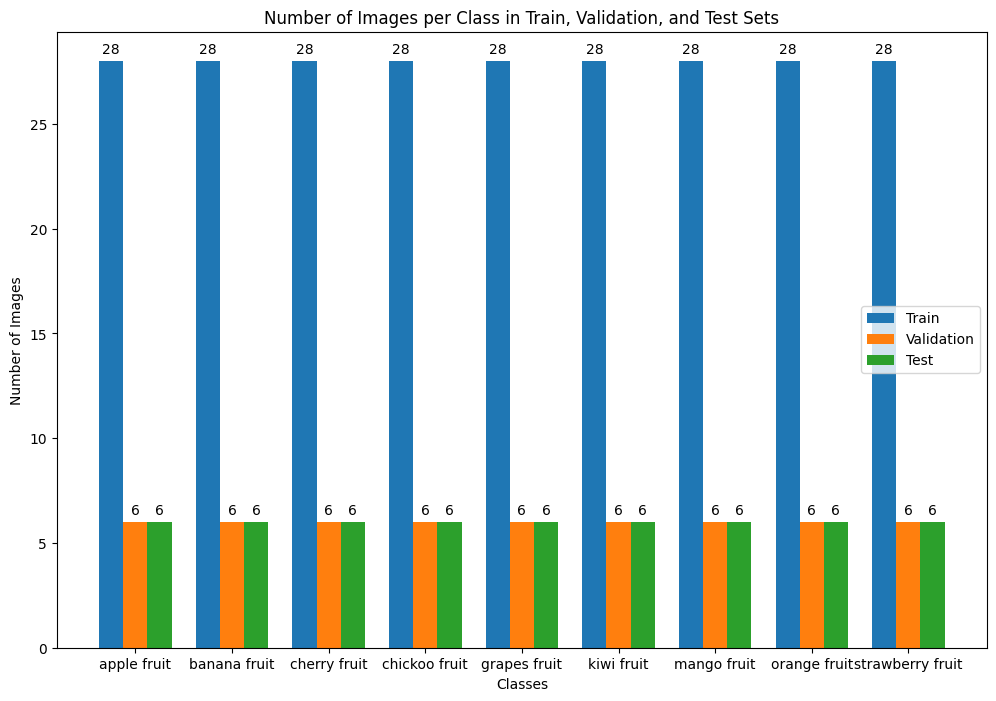

In [18]:

def count_images_in_folder(folder):
    """Counts the number of files in each subfolder of the given folder."""
    counts = {}
    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        if os.path.isdir(class_path):
            counts[class_folder] = len(os.listdir(class_path))
    return counts

# Define paths to your dataset folders
train_path = '/content/drive/MyDrive/Colab Notebooks/split_dataset/train'
val_path = '/content/drive/MyDrive/Colab Notebooks/split_dataset/val'
test_path = '/content/drive/MyDrive/Colab Notebooks/split_dataset/test'

# Count images per class in each dataset
train_counts = count_images_in_folder(train_path)
val_counts = count_images_in_folder(val_path)
test_counts = count_images_in_folder(test_path)

# Prepare data for the bar graph
classes = sorted(train_counts.keys())  # Get a sorted list of classes
train_sizes = [train_counts[cls] for cls in classes]
val_sizes = [val_counts[cls] for cls in classes]
test_sizes = [test_counts[cls] for cls in classes]

# Create a bar graph
x = range(len(classes))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x, train_sizes, width, label='Train')
rects2 = ax.bar([p + width for p in x], val_sizes, width, label='Validation')
rects3 = ax.bar([p + width * 2 for p in x], test_sizes, width, label='Test')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class in Train, Validation, and Test Sets')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(classes)
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

In [19]:
img_width = 230
img_height =230

In [20]:

# Creating datasets
data_train = tf.keras.utils.image_dataset_from_directory(data_train_path, shuffle=True, image_size=(img_width, img_height), batch_size=32)
data_val = tf.keras.utils.image_dataset_from_directory(data_val_path, image_size=(img_width, img_height), batch_size=16, shuffle=False)
data_test = tf.keras.utils.image_dataset_from_directory(data_test_path, image_size=(img_width, img_height), batch_size=16, shuffle=False)


Found 252 files belonging to 9 classes.
Found 54 files belonging to 9 classes.
Found 54 files belonging to 9 classes.


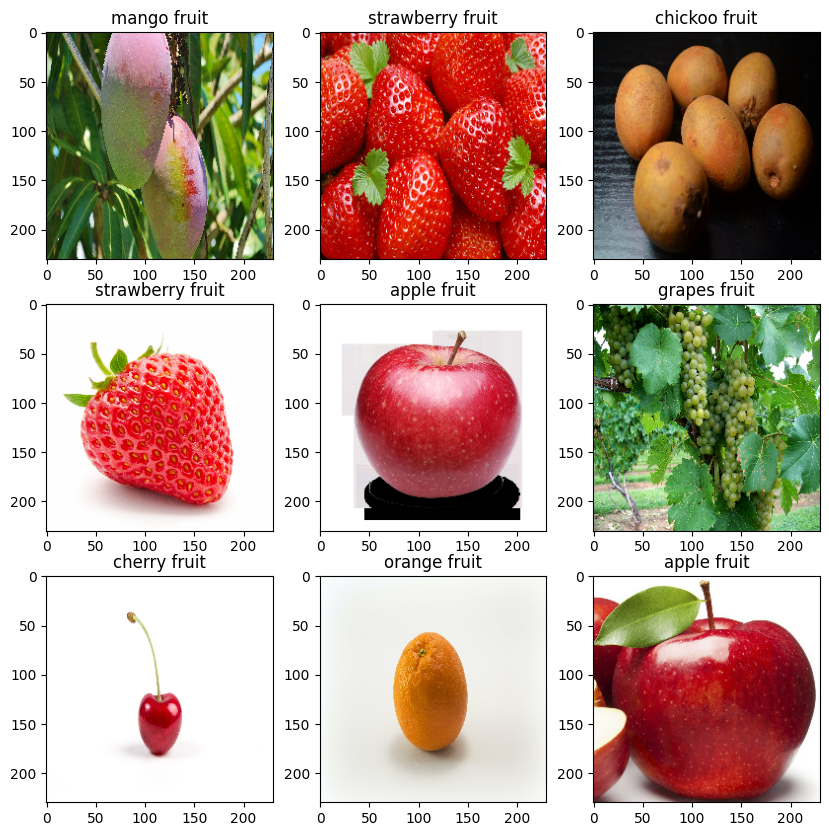

In [21]:
# Visualizing training images
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(data_train.class_names[labels[i]])
        plt.axis('on')

In [38]:
# Defining the model architecture
base_model = EfficientNetB0(include_top=False, input_shape=(img_width, img_height, 3), weights='imagenet')
base_model.trainable = True
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(data_train.class_names), activation='softmax')(x)
model = Model(base_model.input, outputs)


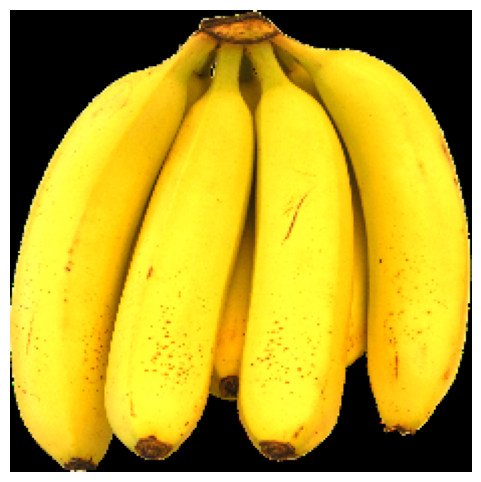

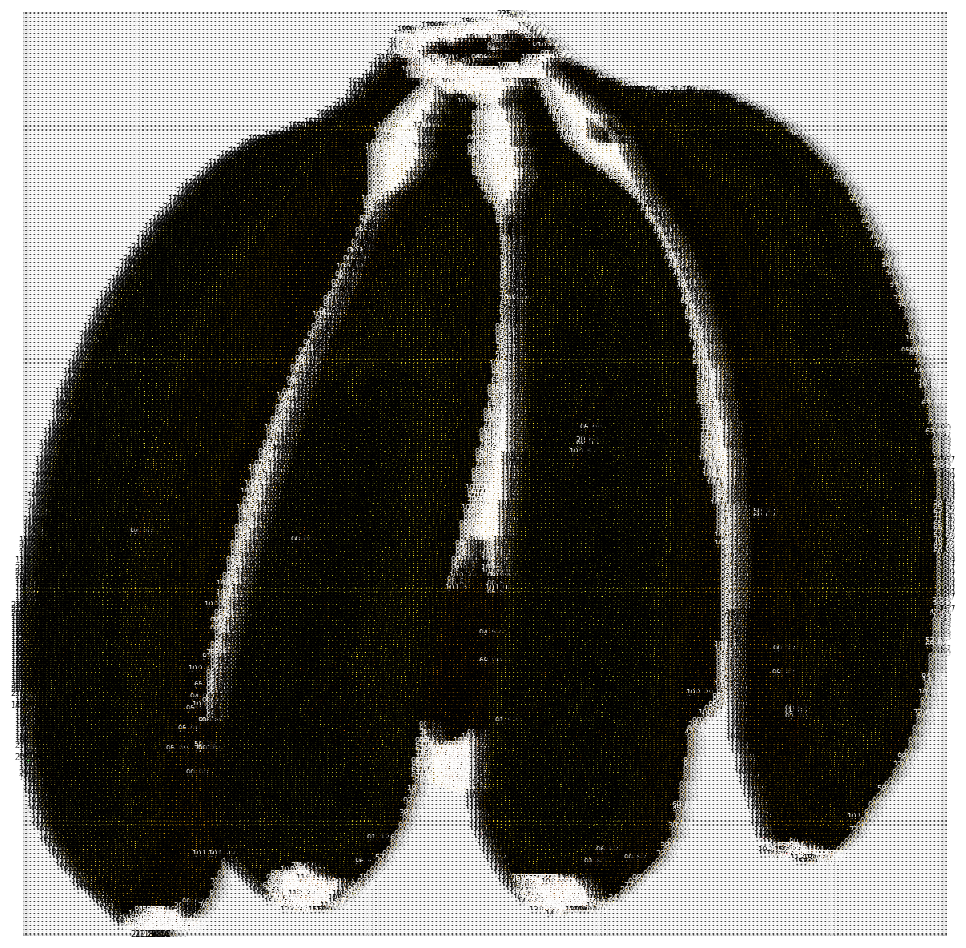

In [23]:

# We want the first batch and specifically one image from that batch
for images, labels in data_train.take(1):
    img = images[2].numpy().astype("uint8")  # Select the third image for example; adjust index as needed

     # Set up the plot
fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and a set of subplots with a custom figure size

# Display the image
ax.imshow(img)  # Display the data as an image, i.e., on a 2D regular raster
ax.axis('off')  # Hide axes for a cleaner image presentation

plt.show()  # Display the figure

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Display the image
ax.imshow(img)

# Get the dimensions of the image
height, width, _ = img.shape

# Set a threshold for text color (based on image intensity)
thresh = img.max() / 2.5

# Iterate through each pixel of the image
for x in range(height):
    for y in range(width):
        # Get the pixel value (for simplicity, average the RGB channels)
        val = np.mean(img[x, y])
        # Annotate the pixel value on the image, rounded to 2 decimal places
        ax.annotate(f'{val:.2f}', xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if val < thresh else 'black', fontsize=6)  # Adjust fontsize as needed

# Turn off axes for cleaner visualization
ax.axis("off")

plt.show()



In [24]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [25]:
# Setting up callbacks for early stopping and best model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
]

In [26]:
# Training the model
history = model.fit(data_train, validation_data=data_val, epochs=24, callbacks=callbacks)


Epoch 1/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3710 - loss: 1.8601

8/8 ━━━━━━━━━━━━━━━━━━━━ 102s 9s/step - accuracy: 0.3915 - loss: 1.8255 - val_accuracy: 0.9074 - val_loss: 0.7112
Epoch 2/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.9074 - loss: 0.5544

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 976ms/step - accuracy: 0.9075 - loss: 0.5461 - val_accuracy: 0.9444 - val_loss: 0.3095
Epoch 3/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.9519 - loss: 0.2454

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9524 - loss: 0.2417 - val_accuracy: 1.0000 - val_loss: 0.1829
Epoch 4/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9855 - loss: 0.1034

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9854 - loss: 0.1044 - val_accuracy: 0.9630 - val_loss: 0.1439
Epoch 5/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9983 - loss: 0.0710

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 806ms/step - accuracy: 0.9980 - loss: 0.0704 - val_accuracy: 0.9630 - val_loss: 0.1252
Epoch 6/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 1.0000 - loss: 0.0469

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 876ms/step - accuracy: 1.0000 - loss: 0.0465 - val_accuracy: 0.9630 - val_loss: 0.1188
Epoch 7/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 1.0000 - loss: 0.0311

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 1.0000 - loss: 0.0310 - val_accuracy: 0.9630 - val_loss: 0.1123
Epoch 8/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 1.0000 - loss: 0.0282

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 0.9815 - val_loss: 0.1068
Epoch 9/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 849ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.9630 - val_loss: 0.1139
Epoch 10/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 768ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.9630 - val_loss: 0.1139
Epoch 11/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 1.0000 - loss: 0.0178 - val_accuracy: 0.9444 - val_loss: 0.1100
Epoch 12/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 871ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.9444 - val_loss: 0.1080
Epoch 13/24
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 863ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 0.9630 - val_loss: 0.1102
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


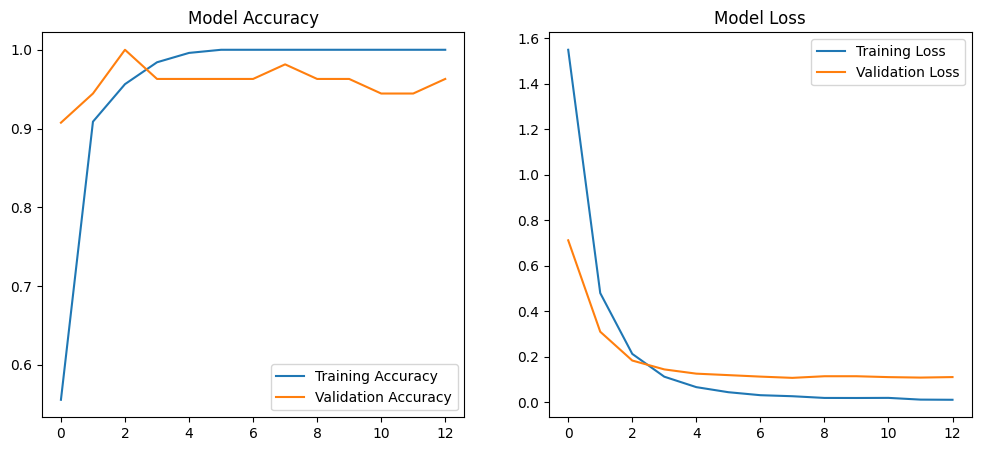

In [27]:
# Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()


In [34]:
image = '/content/drive/MyDrive/Colab Notebooks/split_dataset/val/kiwi fruit/Image_27.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

#predict image

predict = model.predict(img_bat)
score = tf.nn.softmax(predict)
print('Fruit in image is {} with accuracy of {:0.2f}'.format(
    data_train.class_names[np.argmax(score)],
    np.max(score) * 100
))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Fruit in image is kiwi fruit with accuracy of 25.36


In [35]:
predict = model.predict(img_bat)
score = tf.nn.softmax(predict[0])  # [0] since it's a batch with one image

for i, class_name in enumerate(data_train.class_names):
    print(f"{class_name}: {score[i]*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
apple fruit: 9.33%
banana fruit: 9.33%
cherry fruit: 9.33%
chickoo fruit: 9.33%
grapes fruit: 9.33%
kiwi fruit: 25.36%
mango fruit: 9.33%
orange fruit: 9.33%
strawberry fruit: 9.33%


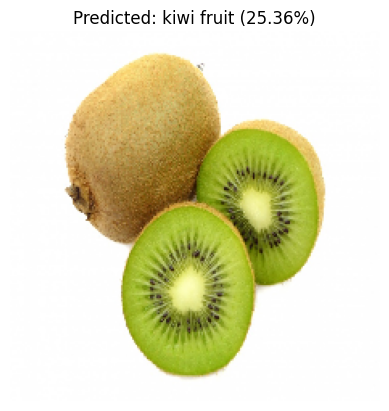

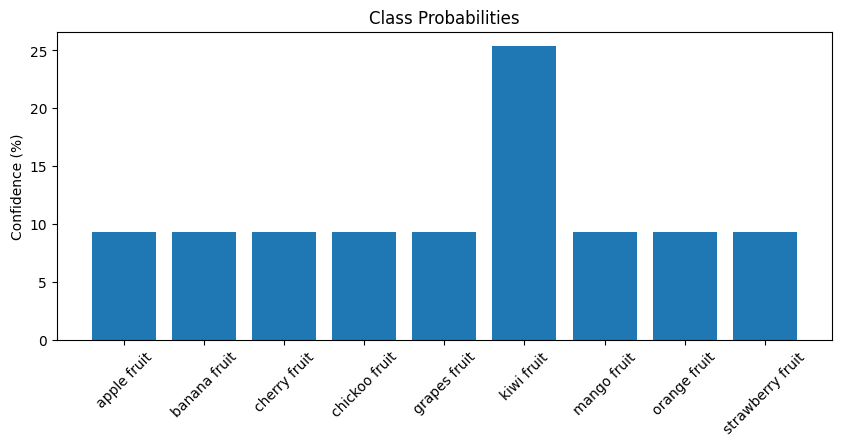

In [36]:

# Display image
plt.imshow(img_bat[0].numpy().astype("uint8"))
plt.axis('off')
plt.title(f"Predicted: {data_train.class_names[np.argmax(score)]} ({np.max(score)*100:.2f}%)")
plt.show()

# Plot class probabilities
plt.figure(figsize=(10,4))
plt.bar(data_train.class_names, score * 100)
plt.ylabel("Confidence (%)")
plt.title("Class Probabilities")
plt.xticks(rotation=45)
plt.show()


In [37]:
print("Classes:", data_train.class_names)
print("Number of classes:", len(data_train.class_names))
print(f"Train: {len(data_train)} batches")
print(f"Validation: {len(data_val)} batches")
print(f"Test: {len(data_test)} batches")


Classes: ['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit', 'grapes fruit', 'kiwi fruit', 'mango fruit', 'orange fruit', 'strawberry fruit']
Number of classes: 9
Train: 8 batches
Validation: 4 batches
Test: 4 batches
